# Ненужные вещи - сегментация пользователей

**Задача:**
- **Исследовать поведение пользователей мобильного приложения "Ненужные вещи"**
- **Провести сегментацию пользователей по поведению и сравнить их конверсию и retention rate**
- **Проверить гипотезы**

**План:**  
  
**1. Загразка данных и библиотек**  
**2. Предобработка данных**  
**3. EDA**  
    3.1 Retention rate  
    3.2 Время, проведённое в приложении  
    3.3 Частота действий  
    3.4 Конверсия в целевое действие — просмотр контактов.  
**4. Сегментация пользователей**  
    4.1 Выделение метрик - источник, время и день захода в приложение  
    4.2 Кластеризация  
**5. Проверка гипотез**
    5.1 

## Загрузка библиотек и данных

In [1]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timedelta, time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
events = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [3]:
users = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')

## Предобработка данных

### События

In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [5]:
events.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


**В датасете 74197 событий. Пропусков похоже нет. Надо перевести время в нужный формат. В названиях точки лучше заменить на нижнее подчеркивание**

In [6]:
#Названия столбцов в змеиный регистр
events.columns = ['event_time', 'event_name', 'user_id']

In [7]:
#Тип даты в datetime
events['event_time'] = pd.to_datetime(events['event_time'], format='%Y-%m-%d %H:%M:%S').dt.round('1S')

In [8]:
events.duplicated().sum()

1118

**Удалим дубликаты**

In [9]:
events = events.drop_duplicates()
events.duplicated().sum()

0

In [10]:
events.isna().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

**Пропусков нет**

In [11]:
# Типы событий
events['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

**Объединить дублирующие типы событий: поиск и просмотр контактов**

In [12]:
# Объединить типы показа контактов
events['event_name'] = events['event_name'].replace('show_contacts', 'contacts_show')

In [13]:
# Cписок типов поиска
search = ['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7']

# Объединить типы поиска
events['event_name'] = events['event_name'].replace(search, 'search')

In [14]:
events['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search',
       'tips_click', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

In [15]:
# Формат date для даты
events['date'] = events['event_time'].dt.date

In [16]:
print (events['date'].min())
print (events['date'].max())

2019-10-07
2019-11-03


**Есть данные за 4 недели: с 7 октября по 3 ноября**

### Пользователи

In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


**4293 пользователя. Приведем user_id к тому же названию, как в events**

In [19]:
users.columns=['user_id', 'source']

In [20]:
users['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

**Датасет содержит ID участников и их источник - яндекс, гугл или другое**

In [21]:
users.duplicated().sum()

0

In [22]:
users.isna().sum()

user_id    0
source     0
dtype: int64

**Дубликатов нет, пропусков нет**

## EDA

### Выделение сессий

In [23]:
# Функция для индексации сессий
# Принимает журнал событий
# Возвращает датафрейм с порядковым номером сессии, временем ее начала и конца, числом событий и id пользователя

def get_sessions(events):
    
    # Датафрейм сортированный по пользователям и времени события
    sessions_raw = (
        events.sort_values(['user_id', 'event_time'])
        .loc[:, ['user_id', 'event_time']]
        .reset_index(drop=True)
    )
    
    # Назначает событиям сквозной порядковый номер сессии.
    # Увеличивает номер на 1 если меняется пользователь или если время между событиями > 30 минут
    sessions_raw['session'] = 1
    for i in range(1, len(sessions_raw)):
        if sessions_raw.loc[i, 'user_id'] == sessions_raw.loc[i-1, 'user_id']:
            if (sessions_raw.loc[i,'event_time'] - sessions_raw.loc[i-1, 'event_time']) < timedelta(minutes=30):
                sessions_raw.loc[i, 'session'] = sessions_raw.loc[i-1, 'session']
            else:
                sessions_raw.loc[i, 'session'] = sessions_raw.loc[i-1, 'session'] + 1
        else:
            sessions_raw.loc[i, 'session'] = sessions_raw.loc[i-1, 'session'] + 1
            
    sessions = sessions_raw.groupby('session').agg({'user_id':'first', 'event_time':['min', 'max', 'count']})
    sessions.columns = ['user_id','start', 'end', 'event_count']
    
    return sessions

In [24]:
sessions = get_sessions(events)

**Длительность сессий**

In [25]:
# Получаем продолжительность сессии в минутах
sessions['duration'] = (sessions['end'] - sessions['start']).dt.seconds / 60
sessions['duration'].describe()

count    10369.000000
mean        12.873681
std         19.842137
min          0.000000
25%          0.350000
50%          5.583333
75%         17.416667
max        321.966667
Name: duration, dtype: float64

**Есть сессии продолжительностью 0 минут - их логично удалить**

In [26]:
sessions = sessions.query('duration != 0')
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8227 entries, 1 to 10369
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      8227 non-null   object        
 1   start        8227 non-null   datetime64[ns]
 2   end          8227 non-null   datetime64[ns]
 3   event_count  8227 non-null   int64         
 4   duration     8227 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 385.6+ KB


In [27]:
sessions.describe()

,event_count,duration
count,8227.000000,8227.000000
mean,8.622341,16.225501
std,9.984571,21.019957
min,2.000000,0.016667
25%,3.000000,3.166667
50%,5.000000,9.300000
75%,10.000000,21.591667
max,149.000000,321.966667


**Выводы:**

- **Выделено 8227 сессий**
- **В среднем в сессии около 9 действий**
- **Средняя продолжительность сессии - 16 минут, медианная - 9 минут**
- **Редкие сессии достигают 5 часов**

### Частота событий

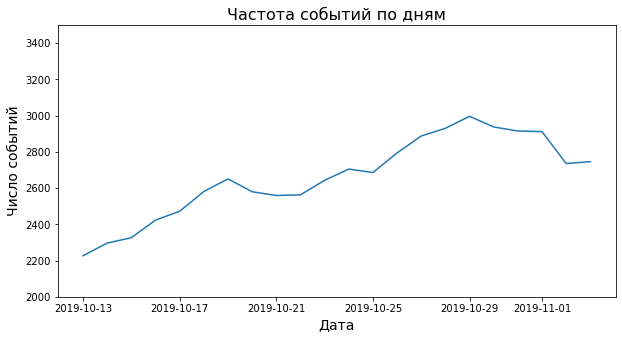

In [28]:
# Число событий по дням со скользящим средним в 7 дней

plt.figure(figsize=(10,5))
plt.plot(events.groupby('date')['event_name'].count().rolling(7).mean())
plt.title('Частота событий по дням', size=16)
plt.ylim(2000,3500)
plt.xlabel('Дата', size=14)
plt.ylabel('Число событий', size=14)
plt.show()

**В течении времени исследования имеется тренд на увеличение**

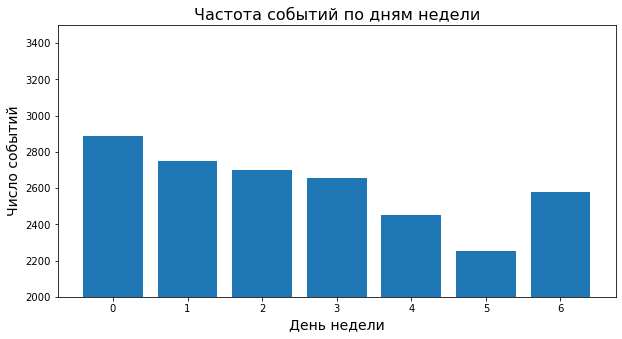

In [29]:
#Сумма событий по дням недели, деленая на 4 (число недель)
weekday_events = (events.groupby(events['event_time'].dt.weekday)
                  .agg({'event_name':'count'})
                  .rename(columns={'event_name':'event_count'})
                  / 4
                 )

# График - среднее число событий по дням недели
plt.figure(figsize=(10,5))
plt.bar(x=weekday_events.index, height=weekday_events['event_count']) 
plt.title('Частота событий по дням недели', size=16)
plt.xlabel('День недели', size=14)
plt.ylabel('Число событий', size=14)
plt.ylim(2000,3500)
plt.show()

**В среднем активность пользователей выше всего в понедельник, снижается в течении недели, ниже всего - в субботу**

In [30]:
# Выделение времени события с округлением до часа

events['hour'] = events['event_time'].dt.floor('H').dt.hour

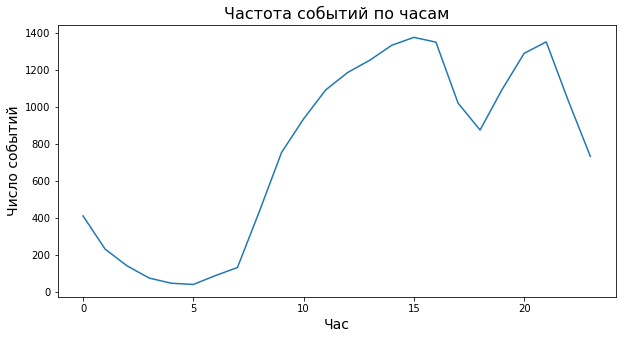

In [31]:
# Число событий по часам в сутки

plt.figure(figsize=(10,5))
plt.plot(events.groupby('hour')['event_name'].count()/4)
plt.title('Частота событий по часам', size=16)
plt.xlabel('Час', size=14)
plt.ylabel('Число событий', size=14)
plt.show()

**Больше всего событий совершают в районе обеда (14-16 часов) и вечером (20-21 час).  
Локальный минимум - 17-19 часов (очевидно, время дороги с работы домой)**

### Динамика привлечения пользователей

In [32]:
# Профили пользователей с временем первой сессии и источниками посещений

profiles = users.merge(sessions.groupby('user_id')['start'].min().reset_index(), on='user_id')
profiles = profiles.rename(columns={'start':'first_session'})

In [33]:
# Дата первой сессии
profiles['first_date'] = profiles['first_session'].dt.date

In [34]:
profiles

,user_id,source,first_session,first_date
0,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,2019-10-07
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02,2019-10-07
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,2019-10-07 00:02:07,2019-10-07
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other,2019-10-07 00:05:20,2019-10-07
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google,2019-10-07 00:09:34,2019-10-07
...,...,...,...,...
4201,b86fe56e-f2de-4f8a-b192-cd89a37ecd41,yandex,2019-11-03 23:10:03,2019-11-03
4202,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,yandex,2019-11-03 23:22:52,2019-11-03
4203,437a4cd4-9ba9-457f-8614-d142bc48fbeb,yandex,2019-11-03 23:44:22,2019-11-03
4204,c10055f0-0b47-477a-869e-d391b31fdf8f,yandex,2019-11-03 23:46:31,2019-11-03


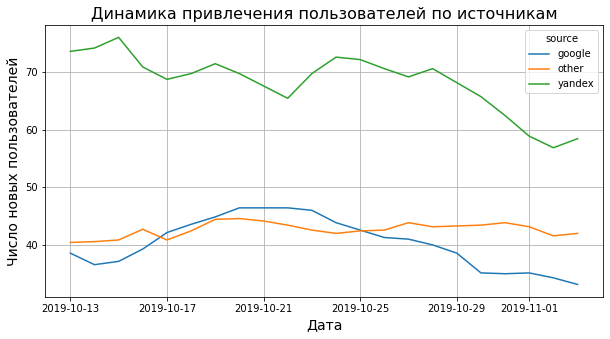

In [35]:
# График: динамика привлечения пользователей по источникам со скользящим средним в 7 дней

profiles.pivot_table(
    index='first_date', 
    columns='source',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).rolling(7).mean().plot(figsize=(10, 5), grid=True)
plt.title('Динамика привлечения пользователей по источникам', size=16)
plt.xlabel('Дата', size=14)
plt.ylabel('Число новых пользователей', size=14)

plt.show()

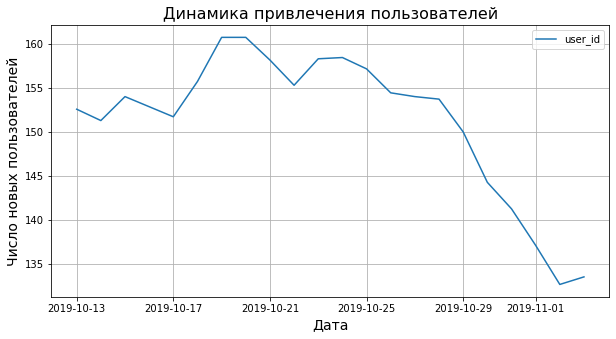

In [36]:
# График: общая динамика привлечения пользователей со скользящим средним в 7 дней

profiles.pivot_table(
    index='first_date', 
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).rolling(7).mean().plot(figsize=(10, 5), grid=True)
plt.title('Динамика привлечения пользователей', size=16)
plt.xlabel('Дата', size=14)
plt.ylabel('Число новых пользователей', size=14)

plt.show()

**Выводы:**

- **Яндекс стабильно привлекает больше новых пользователей.** 
- **Гугл и другие источники привлекают примерно одинаковое число пользователей.** 
- **В течение рассматриваемого периода привлечение новых пользователей снижается**

### Конверсия пользователей в просмотр контактов

In [37]:
# Определение пользователей, посмотревших контакты

buyers = events.query('event_name=="contacts_show"')['user_id'].unique()

In [38]:
# Индексация посмотревших контакты в профилях пользователей

profiles['buyer'] = profiles['user_id'].isin(buyers)

In [39]:
print ('Покупателей:')
profiles['buyer'].sum()

Покупателей:


972

In [40]:
print ('Не покупателей:')
profiles['buyer'].count() - profiles['buyer'].sum()

Не покупателей:


3234

In [41]:
# Общая конверсия
total_convertion = (profiles['buyer'].sum() / profiles['buyer'].count())
print ('Общая конверсия: {:.2}'.format(total_convertion))

Общая конверсия: 0.23


**Общая конверсия за рассматриваемый период - 0.23 (почти каждый 4 пользователь доходит до просмотра контактов продавца)**

#### Число просмотров контактов пользователем за день

**Можно посчитать среднее число просмотров контактов пользователем в день в качестве целевой метрики активности пользователей**

In [42]:
# Общее число просмотров контактов пользователем

contacts_shown = (
    events.query('event_name=="contacts_show"')
    .groupby('user_id')
    .agg({'event_name':'count'})
    .reset_index()
)

# Присоединяем общее число просмотров к профилям пользователей
profiles = profiles.merge(contacts_shown, on='user_id', how='left')
profiles = profiles.rename(columns={'event_name':'contacts_shown'})

# Пользователям без просмотров контактов проставляем 0
profiles['contacts_shown'] = profiles['contacts_shown'].fillna(0)

In [43]:
# Функция для расчета среднего числа просмотров контактов в день начиная с даты прихода пользователя в приложение

def get_dayly_contacts_shown (profiles):
    days = (datetime(2019, 11, 3).date() - profiles['first_date']).days + 1
    result = profiles['contacts_shown'] / days
    return result

In [44]:
# Считаем среднее число просмотров контактов пользователем в день
profiles['dayly_contacts_shown'] = profiles.apply(get_dayly_contacts_shown, axis=1)

In [45]:
print ('Среднее число просмотров контактов в день:')
profiles['dayly_contacts_shown'].mean()

Среднее число просмотров контактов в день:


0.1022689594873511

**Усредненный пользователь просматривает 0.1 контакт в день (1 контакт за 10 дней)**

In [46]:
# Сколько контактов просматривают покупатели (пользователи, в принципе дошедшие до просмотра контактов)
print ('Среднее число просмотров контактов в день покупателями:')
profiles.query('buyer==True')['dayly_contacts_shown'].mean()

Среднее число просмотров контактов в день покупателями:


0.4425342012384761

**Пользователи, которые дошли до просматра контактов, просматривают 0.43 контакта в день (примерно 1 контакт в 2 дня)**

#### Дневная конверсия

In [47]:
# Функция для таблицы конверсии за день
def get_day_conversion (events):
    
# Число уникальных пользователей в день
    conversion_date = events.groupby('date').agg({'user_id':'nunique'})
    conversion_date.columns = ['users']

# Число уникальных пользователей, посмотревших контакты в день
    conversion_date['contacts_shown'] = events.query('event_name=="contacts_show"').groupby('date').agg({'user_id':'nunique'})

# Конверсия в день
    conversion_date['conversion'] = conversion_date['contacts_shown'] / conversion_date['users']
    return conversion_date

In [48]:
conversion_date = get_day_conversion (events)

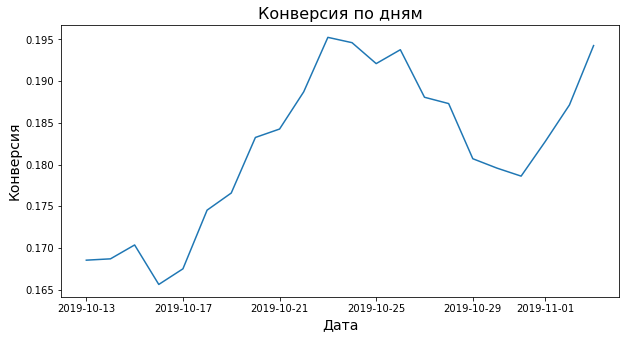

In [49]:
# Конверсия по дням со скользящим средним в 7 дней

plt.figure(figsize=(10,5))
plt.plot(conversion_date['conversion'].rolling(7).mean())
plt.title('Конверсия по дням', size=16)
plt.xlabel('Дата', size=14)
plt.ylabel('Конверсия', size=14)
plt.show()

**Конверсия за рассматриваемый период растет. Есть периодическая динамика по неделям**

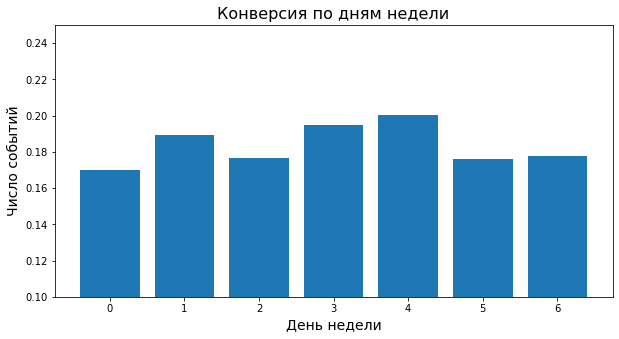

In [50]:
# Средняя конверсия по дням недели

weekday_conversion = (
    conversion_date.groupby(
        pd.to_datetime(conversion_date.index)
        .weekday)
    .agg({'conversion':'mean'})
)

plt.figure(figsize=(10,5))
plt.bar(x=weekday_conversion.index, height=weekday_conversion['conversion'])
plt.title('Конверсия по дням недели', size=16)
plt.xlabel('День недели', size=14)
plt.ylabel('Число событий', size=14)
plt.ylim(0.1,0.25)
plt.show()

**В среднем максимальная конверсия в четверг и пятницу, минимальная - в понедельник. Но четкой зависимости в течении недели нет**

In [51]:
# Число уникальных пользователей в каждый час
conversion_hour = (events.groupby('hour').agg({'user_id':'nunique'}))
conversion_hour.columns = ['users']

# Число уникальных пользователей, посмотревших контакты в каждый час
conversion_hour['contacts_shown'] = events.query('event_name=="contacts_show"').groupby('hour').agg({'user_id':'nunique'})
conversion_hour = conversion_hour.reset_index()

# Среднее число посетителей и посмотревших контакты за час в сутки
conversion_hour = conversion_hour.groupby('hour').agg({'users':'mean', 'contacts_shown':'mean'})

# Конверсия в час
conversion_hour['conversion'] = conversion_hour['contacts_shown'] / conversion_hour['users']

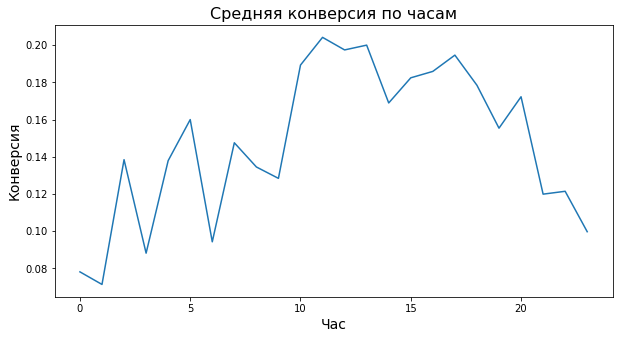

In [52]:
# График средней конверсии по часам в сутки

plt.figure(figsize=(10,5))
plt.plot(conversion_hour['conversion'])
plt.title('Средняя конверсия по часам', size=16)
plt.xlabel('Час', size=14)
plt.ylabel('Конверсия', size=14)
plt.show()

**Наиболее высокая конверсия в течении дня (10-17 часов), вечером, ночью и утром - ниже**

### Время, проведённое в приложении

In [53]:
# Средняя продолжительность сессий для пользователей
profiles = (
    profiles.join(sessions.groupby('user_id')['duration'].mean()
                  , on='user_id'
                  , how='left'
                 )
    .rename(columns={'duration':'mean_duration'})
)

In [54]:
# Среднее число событий за сессию для пользователя
profiles = profiles.merge(sessions.groupby('user_id')['event_count'].mean(), on='user_id')

In [55]:
profiles['mean_duration'].isna().sum()

0

In [56]:
# Пропуски в mean_duration заполняем нулями
profiles['mean_duration'] = profiles['mean_duration'].fillna(0)

In [57]:
profiles['mean_duration'].describe()

count    4206.000000
mean       15.989008
std        16.658228
min         0.016667
25%         5.054167
50%        10.916667
75%        21.432197
max       217.500000
Name: mean_duration, dtype: float64

**У 75% пользователей сессии меньше 22 минут**

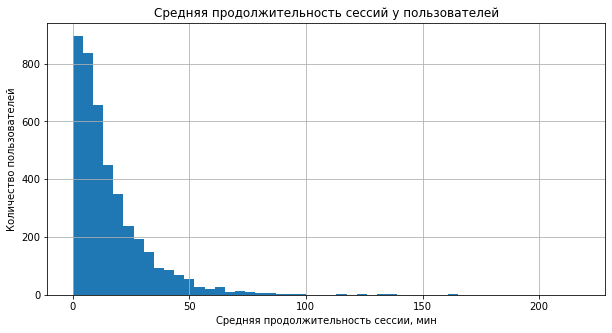

In [58]:
# Гистограмма средней продолжительности сессий по пользователям

plt.figure(figsize=(10,5))
profiles['mean_duration'].hist(bins=50)
plt.title('Средняя продолжительность сессий у пользователей')
plt.xlabel('Средняя продолжительность сессии, мин')
plt.ylabel('Количество пользователей')
plt.show()

**Распределение Пуассона, у большинства пользователей среднее время сессии очень короткое**

In [59]:
# Верхний процентиль продолжительности сессии
np.percentile(profiles['mean_duration'], 99)

75.4641666666666

**Больше 75 минут в приложении проводит только 1% пользователей**

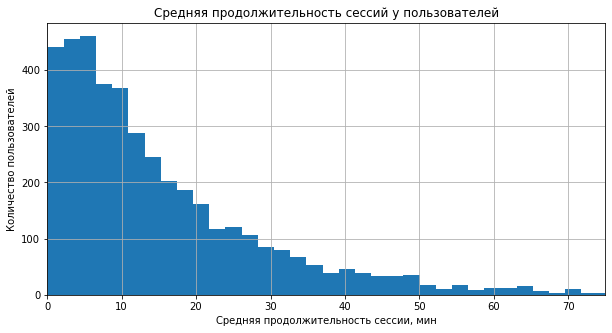

In [60]:
# Гистограмма средней продолжительности сессий по пользователям без верхнего процентиля

plt.figure(figsize=(10,5))
profiles['mean_duration'].hist(bins=100)
plt.title('Средняя продолжительность сессий у пользователей')
plt.xlabel('Средняя продолжительность сессии, мин')
plt.ylabel('Количество пользователей')
plt.xlim(0,75)
plt.show()

**Много пользователей со средней продолжительностью сессии до 6 минут, дальше количество пользователей снижается**

**Отличается ли конверсия для пользователей которые проводят меньше или больше 6 минут в приложении?**

In [61]:
profiles.query('mean_duration < 6')['buyer'].mean()

0.21082390953150243

In [62]:
profiles.query('mean_duration > 6')['buyer'].mean()

0.23952702702702702

**У тех кто проводит более 6 минут в приложении конверсия выше**

### Retention rate по дням

Определить горизонт анализа, расчитать лайфтаймы, построить таблицу удержания, определить размеры когорт, расчитать Retention rate

In [63]:
# Функция для расчета удержания

def get_retention(
    profiles, sessions, observation_date, horizon_days, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('first_date <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['start'] - result_raw['first_session']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index='first_date', columns='lifetime', values='user_id', aggfunc='nunique'
    )
    
    # Размеры когорт
    cohort_sizes = (
        result_raw.groupby('first_date')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='first_date', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

In [64]:
# Расчет удержания, момент анализа - последнее число периода (2019-11-03), горизонт анализа - неделя
retention_raw, retention = get_retention(
    profiles, sessions, datetime(2019, 11, 3).date(), 7
)

retention.head()

,cohort_size,0,1,2,3,4,5,6
first_date,,,,,,,,
2019-10-07,186,1.0,0.096774,0.069892,0.069892,0.037634,0.026882,0.053763
2019-10-08,161,1.0,0.124224,0.086957,0.049689,0.031056,0.055901,0.037267
2019-10-09,163,1.0,0.049080,0.042945,0.018405,0.036810,0.042945,0.030675
2019-10-10,165,1.0,0.066667,0.084848,0.054545,0.084848,0.060606,0.066667
2019-10-11,131,1.0,0.061069,0.061069,0.076336,0.045802,0.045802,0.076336


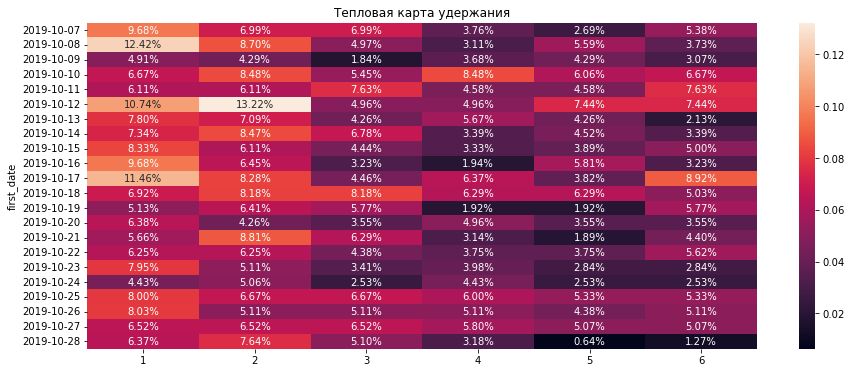

In [65]:
plt.figure(figsize = (15, 6))  # задаём размер графика
sns.heatmap(retention.drop(columns = ['cohort_size', 0]), # удаляем размеры когорт
            annot = True,  # включаем подписи
            fmt = '.2%'  # отображаем значения в виде процентов
           )
plt.title('Тепловая карта удержания')  # название графика
plt.show()

**Динамика удержания по дням не выглядит представительной, так как пользователи пользуются приложением не каждый день, так что явной динамики не видно. Удержание по неделям может быть более показательным**

### Retention rate по неделям

In [66]:
# Функция определяет неделю и возвращает первое число недели

def get_week(date_time):
    if date_time.date() < datetime(2019, 10, 14).date():
        result = datetime(2019, 10, 7)
    elif date_time.date() < datetime(2019, 10, 21).date():
        result = datetime(2019, 10, 14)
    elif date_time.date() < datetime(2019, 10, 28).date():
        result = datetime(2019, 10, 21)
    elif date_time.date() < datetime(2019, 11, 4).date():
        result = datetime(2019, 10, 28)
    return result

In [67]:
# Получаем недели сессий
sessions['start_week'] = sessions['start'].apply(get_week)

In [68]:
# Получаем недели прихода пользователей
profiles['first_week'] = profiles['first_session'].apply(get_week)

In [69]:
# Функция для расчета удержания по неделям

def get_week_retention(
    profiles, sessions, observation_date, horizon_weeks, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            weeks=horizon_weeks - 1
        )
    result_raw = profiles.query('first_week <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'start_week']], on='user_id', how='left'
    )
    result_raw['lifetime'] = ((
        result_raw['start_week'] - result_raw['first_week']
    ).dt.days / 7).astype(int)

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index='first_week', columns='lifetime', values='user_id', aggfunc='nunique'
    )
    
    # Размеры когорт
    cohort_sizes = (
        result_raw.groupby('first_week')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='first_week', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_weeks))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

In [70]:
# Удержание пользователей по неделям
# Горизонт анализа - 4 недели (берем данные пришедших только в первую неделю)

retention_week_raw, retention_week = get_week_retention(
    profiles, sessions, datetime(2019, 11, 3).date(), 4
)

retention_week

,cohort_size,0,1,2,3
first_week,,,,,
2019-10-07,1068,1.0,0.187266,0.117978,0.077715


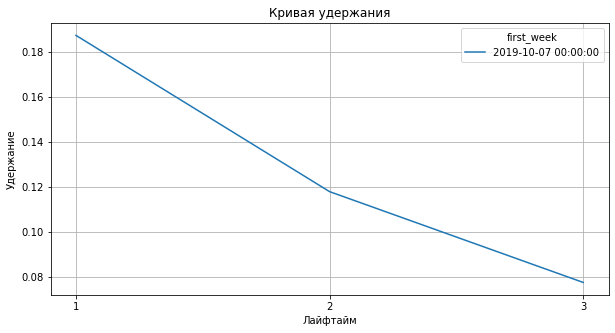

In [71]:
report = retention_week.drop(columns = ['cohort_size', 0])

report.T.plot(
    grid=True, 
    xticks=list(report.T.index), 
    figsize=(10, 5), 
)
plt.xlabel('Лайфтайм') 
plt.ylabel('Удержание')
plt.title('Кривая удержания') 
plt.show()

**Вывод:**

- **Удержание по неделям нормально передает динамику удержания пользователей**
- **Во вторую неделю возвращается 20% пользователей, в третью - 13%, в четвертую - 9%**

#### Вывод по EDA

- **События объеденены в сессии, средняя продолжительность сессии - 16 минут**
- **У 75% пользователей сессии меньше 22 минут**
- **Яндекс стабильно привлекает больше новых пользователей. В течение рассматриваемого периода привлечение новых пользователей снижается**
- **В приложении совершается 2000-3000 действий в сутки. В течение рассматриваемого периодачастота действий растет**
- **Средняя конверсия - 0.23, в течении рассматриваемого периода дневная конверсия растет**
- **Retention rate во вторую неделю - 20%, в третью - 13%, в четвертую - 9%**

## Сегментация пользователей

**По данным EDA, помимо источника перехода, на конверсию может влиять время захода в приложение и среднее время сессии**

**Добавим индексацию пользователей, заходящих с 10 до 17 часов (когда конверсия выше)**

In [72]:
# Время начала сессии
sessions['start_time'] = sessions['start'].dt.time

In [73]:
# Индексация пользователей, заходящих с 10 до 17 часов

profiles['day_visitor'] = (
    profiles['user_id'].isin(
        sessions.query('start_time >= @time(10,0,0) & start_time < @time(17,0,0)')
        ['user_id'].unique()
    )
)

**Переведем источники перехода в отдельные столбцы для кластеризации**

In [74]:
profiles['yandex'] = profiles['source']=="yandex"
profiles['google'] = profiles['source']=="google"
profiles['other'] = profiles['source']=="other"

### Разделение пользователей на группы

**Для кластеризации используем показатели: источник прихода, среднее время сессии, среднее число действий за сессию, наличие использования приложения с 10 до 17 часов, среднее число просмотров контактов в день**

#### Иерархическая кластеризация

In [75]:
# Случайная подвыборка для кластеризации
X = profiles[['yandex', 'google', 'other', 'mean_duration', 'event_count', 'day_visitor', 'dayly_contacts_shown']].sample(n=500, axis=0)

In [76]:
# Cтандартизация признаков
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [77]:
# Таблица связей
linked = linkage(X_sc, method = 'ward')

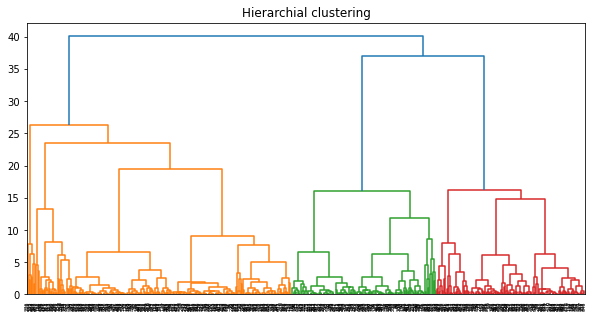

In [78]:
# Построение дендрограммы
plt.figure(figsize=(10, 5))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show() 

**Рекомендуемое число кластеров - 3 или 4 (3 крупных и один небольшой)**

#### K-means

In [79]:
# Признаки для анализа
X = profiles[['yandex', 'google', 'other', 'mean_duration', 'event_count', 'day_visitor', 'dayly_contacts_shown']]

In [98]:
# Стандартизация
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [99]:
# Определение кластеров
km = KMeans(n_clusters=4, random_state=0)
labels = km.fit_predict(X_sc)

In [100]:
# Добавление номеров кластеров к профилям пользователей
profiles['group'] = labels

### Сравнение групп

In [101]:
profiles['group'].value_counts()

2    1741
3    1134
1    1050
0     281
Name: group, dtype: int64

**Пользователи образовали три крупных кластера и один небольшой**

In [102]:
profiles.groupby('group').mean()

,buyer,contacts_shown,dayly_contacts_shown,mean_duration,event_count,day_visitor,yandex,google,other
group,,,,,,,,,
0,0.348754,4.750890,0.539921,56.682003,30.658457,0.530249,0.551601,0.227758,0.220641
1,0.233333,0.815238,0.075178,13.982503,7.697176,0.539048,0.000000,1.000000,0.000000
2,0.241241,0.811028,0.071574,13.423766,7.241398,0.572085,1.000000,0.000000,0.000000
3,0.184303,0.672840,0.066030,11.701694,7.103051,0.579365,0.000000,0.000000,1.000000


**Описание кластеров:**
- **0 - Активные пользователи. Переходят из разных источников, но в основном из Яндекса, очень длинные сессии (56 минут) с большим количеством действий, самая высокая конверсия (0.37), большое число просмотров контактов (в среднем почти 6 за день)**
- **1 - Гугл. 2 - Яндекс. В обеих группах похожая конверсия (0.23-0.24), средняя длина сессии (14 минут), просмотров контактов за день в среднем чуть больше у пользователей из Яндекса**
- **3 - Другие источники. Наименьшая длина сессии (12 минут) и конверсия (0.18)**

In [103]:
profiles['group'] = profiles['group'].replace({0:'Актив', 1:'Google', 2:'Яндекс', 3:'Другие'})

#### Конверсия

**Отдельно оценка конверсии (хотя она уже оценена по столбцу buyer)**

In [104]:
# Таблица конверсии для кластеров
group_conversion = profiles.groupby('group').agg({'buyer':['sum', 'count']})
group_conversion.columns=(['sum', 'count'])
group_conversion['conversion'] = group_conversion['sum'] / group_conversion['count']

In [105]:
group_conversion

,sum,count,conversion
group,,,
Google,245,1050,0.233333
Актив,98,281,0.348754
Другие,209,1134,0.184303
Яндекс,420,1741,0.241241


**Лучшая конверсия у активных пользователей, худшая - у пользователей из других источников**

#### Retention rate

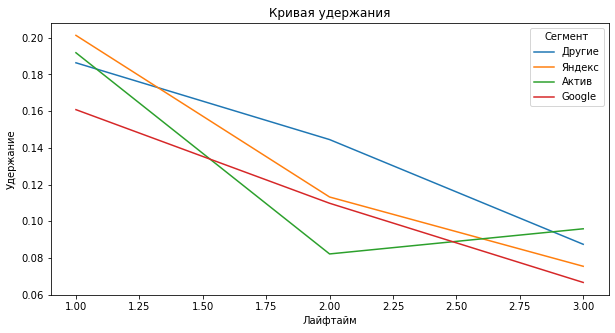

In [106]:
# График удержания по неделям для разных групп

plt.figure(figsize=(10, 5))
labels=[]

# Таблицы удержания для каждой группы
for i in profiles['group'].unique():
    retention_week_raw_group, retention_week_group = get_week_retention(
        profiles.query('group==@i'),
        sessions,
        datetime(2019, 11, 3).date(),
        4
    )
    
    report = retention_week_group.drop(columns = ['cohort_size', 0])
    
    # Графики удержания для каждой группы
    plt.plot(report.T)
    plt.grid=True, 
    plt.xticks=list(report.T.index)
    labels.append(i)

# Оформление итогового графика
plt.legend(title='Сегмент', labels=labels)
plt.xlabel('Лайфтайм') 
plt.ylabel('Удержание')
plt.title('Кривая удержания') 
plt.show()

**Удержание ко 2-й и 3-й неделе лучше у пользователей из других источников.**  
**Удержание Яндекса резко снижается к 3-й неделе**  
**На последней неделе в топ выходит удержание у Активных пользователей, которое растет по сравнению с третьей неделей - видимо это эффект того, что этих пользователей мало, и даже недельное удержание плохо передает их поведение**

## Проверка гипотез

### Пользователи из гугла и яндекса различаются по конверсии

**Нулевая гипотеза - конверсия пользователей из Яндекса и Гугла одинакова**

In [107]:
# Конверсия по источникам
source_conversion = profiles.groupby('source').agg({'buyer':['sum', 'count']})
source_conversion.columns=('buyer', 'total')
source_conversion['conversion'] = source_conversion['buyer'] / source_conversion['total']
source_conversion

,buyer,total,conversion
source,,,
google,273,1114,0.245063
other,224,1196,0.187291
yandex,475,1896,0.250527


In [108]:
# Расчет Z-критерия
p1 = source_conversion.loc['google', 'conversion']
p2 = source_conversion.loc['yandex', 'conversion']

p_combined = (
    (source_conversion.loc['google', 'buyer'] + source_conversion.loc['yandex', 'buyer'])
    /
    (source_conversion.loc['google', 'total'] + source_conversion.loc['yandex', 'total'])
)

z_value = (p1 - p2) / math.sqrt(p_combined * (1 - p_combined) * (1/source_conversion.loc['google', 'total'] + 1/source_conversion.loc['yandex', 'total']))

In [109]:
# Нормальное распределение и p-value
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2

In [110]:
# Проверка достоверности

alpha = 0.05

print ('p_value: {:.2}'.format(p_value))
if p_value > alpha:
    print ('Не получилось отвергнуть H0')
elif p_value <= alpha:
    print ('Можно отвергнуть H0')

p_value: 0.74
Не получилось отвергнуть H0


**Пользователи из Яндекса и Гугла не отличаются по конверсии с достаточной значимостью**

### Пользователи заходящие в разное время различаются по конверсии

**Так как конверсия днем (с 10 до 17) была выше, чем в остальное время, возможно разделить пользователей на 2 группы по времени захода в приложение**

**Нулевая гипотеза - конверсия дневных пользователей и остальных одинакова**

In [111]:
# Конверсия по наличию дневных заходов

time_conversion = profiles.groupby('day_visitor').agg({'buyer':['sum', 'count']})
time_conversion.columns=('buyer', 'total')
time_conversion['conversion'] = time_conversion['buyer'] / time_conversion['total']
time_conversion

,buyer,total,conversion
day_visitor,,,
False,305,1838,0.165941
True,667,2368,0.281672


In [112]:
# Расчет Z-критерия
p1 = time_conversion.loc[True, 'conversion']
p2 = time_conversion.loc[False, 'conversion']

p_combined = (
    (time_conversion.loc[True, 'buyer'] + time_conversion.loc[False, 'buyer'])
    /
    (time_conversion.loc[True, 'total'] + time_conversion.loc[False, 'total'])
)

z_value = (p1 - p2) / math.sqrt(p_combined * (1 - p_combined) * (1/time_conversion.loc[True, 'total'] + 1/time_conversion.loc[False, 'total']))

In [113]:
# Нормальное распределение и p-value
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2

In [114]:
# Проверка достоверности

alpha = 0.05

print ('p_value: {:.2}'.format(p_value))
if p_value > alpha:
    print ('Не получилось отвергнуть H0')
elif p_value <= alpha:
    print ('Можно отвергнуть H0')

p_value: 0.0
Можно отвергнуть H0


**Конверсия с 10 до 17 и в остальное время статистически значимо различается**

## Выводы

### Поведение пользователей

- **Активность пользователей выше всего в понедельник, снижается в течении недели, ниже всего - в субботу**
- **Больше всего событий совершают в районе обеда (14-16 часов) и вечером (20-21 час), локальный минимум - 17-19 часов**
- **Общая конверсия в просмотр контактов за рассматриваемый период - 0.23**
- **Конверсия за рассматриваемый период растет**
- **Наибольшая конверсия - в дневной период (с 10 до 17 часов)**

### Привлечение новых пользователей
- **Яндекс стабильно привлекает больше новых пользователей**
- **Гугл и другие источники привлекают примерно одинаковое число пользователей**
- **В течение рассматриваемого периода привлечение новых пользователей снижается**

### Сегментация пользователей

- **Пользователей можно разделить на 4 сегмента: по источнику привлечения (Яндекс, Гугл, Другое) и небольшой кластер наиболее активных пользователей**
- **Наибольшая конверсия - у активных пользователей (0.34), у Яндекса и Гугла - 0.23-0.24, наименьшая - у пользователей из других источников (0.18)**
- **Удержание у Гугла лучше, чем у Яндекса. Самое низкое - у других источников**

### Проверка гипотез

- **Яндекс и Гугл не отличаются по конверсии при alpha=0.05**
- **Конверсия у дневных пользователей (10-17 часов) и остальных различается при alpha=0.05**

## Рекомендации для отдела маркетинга

- **Наиболее ценные клиенты - небольшая группа активных пользователей, которые отличаются долгими сессиями с большим количеством действий и высокой конверсией. Стоит удержать их, возможно предложив какие-либо особые условия**
- **Удержание у Яндекса провисает. Возможно стоит запустить какие-либо напоминания или лучшие рекомендации для пользователей, пришедших из Яндекса**
- **Пользователи из других источников кроме Яндекса и Гугла - наименее активные клиенты. Ориентировать рекламные затраты на другие источники представляется нецелесообразным**
- **За рассматриваемый период снижается привлечение новых пользователей в приложение. Стоит пересмотреть рекламный бюджет. Рекомендуется направить его на Яндекс, так как он привлекает больше пользователей, в том числе в группу активных клиентов**

## Презентация

https://drive.google.com/file/d/1cOfqQpCuUSQlyqZpPbnQBCrOA1m_LXkM/view?usp=sharing